In [1]:
import pandas as pd
import numpy as np
import wandb

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, ChannelJitter, RandomNoise
from Network import Unet, ssim_loss, ConvolutionBlock, ASPP

path = "datasets/" + "with_labels/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
df_z = df[df["mean"] < 0.2].sample(frac=0.1, random_state=0)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
5,-3.95,-54.78,2021,5,1,0.94,Labeled_-3.95_-54.78_2021_05_01_0.94.npy
7,-4.03,-54.72,2020,8,1,0.46,Labeled_-4.03_-54.72_2020_08_01_0.46.npy
9,-3.47,-54.78,2018,6,1,0.58,Labeled_-3.47_-54.78_2018_06_01_0.58.npy
11,-4.19,-54.98,2020,8,1,0.74,Labeled_-4.19_-54.98_2020_08_01_0.74.npy
13,-3.77,-54.76,2019,8,1,0.32,Labeled_-3.77_-54.76_2019_08_01_0.32.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df, validaion=False):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        if validaion:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                #transforms.CenterCrop((64, 64)),
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.5),
                
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
                
                transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.2),
                transforms.RandomApply([RandomNoise(0.2)], p=0.2),
            ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :], img[-1, :, :]

positions = df[["lat", "lon"]].drop_duplicates()
positions.sort_index(inplace=True)

# Results depend on validation set, so we fix the seed
train_positions = positions.sample(frac=0.8, random_state=0)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df, validaion=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds) * 4, shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

val_ds.positions # 31, 62, 65, ..., 16738, 16902, 17153

,lat,lon
31,-3.43,-54.90
62,-3.43,-55.12
65,-4.05,-54.92
68,-4.07,-55.04
73,-3.59,-54.50
...,...,...
16290,-4.19,-54.50
16653,-3.89,-55.02
16738,-3.37,-54.94
16902,-3.41,-55.10


In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

tensor([-0.1497, -0.1266, -0.4931, -0.0725, -0.2196,  0.1070,  0.1522,  0.5130,
        -0.1596, -0.1367, -0.5057, -0.0814, -0.2544,  0.0581,  0.1179,  0.5067,
        -0.2140, -0.1984, -0.5790, -0.1545, -0.3455, -0.0431,  0.0134,  0.6781])
tensor([0.5497, 0.5616, 0.5526, 0.5825, 1.0985, 1.0132, 0.8613, 0.8584, 0.5358,
        0.5469, 0.5400, 0.5628, 1.0921, 0.9560, 0.8140, 0.8621, 0.3862, 0.3974,
        0.4004, 0.4166, 0.9069, 0.8020, 0.6687, 0.7350])


In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(8, 16),
            ASPP(16, 16),
        )

        self.unet = Unet(16 * 3, 16)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 1000000

        return x

model = Network().to(device)

In [5]:
@torch.no_grad()
def plot_images():
    im, lb = next(iter(val_dl))
    im, lb = im.to(device), lb.to(device)

    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label, vmin=0, vmax=1)
    axes[4].imshow(output, vmin=0, vmax=1)
    plt.show()

In [6]:
@torch.no_grad()
def f1_score(dl):
    im, lb = next(iter(dl))
    im, lb = im.to(device), lb.to(device)

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?

    return float(f1), float(iou)

In [7]:
ssim_factor = 2
bce_loss = nn.BCEWithLogitsLoss()
loss_fn = lambda output, target: bce_loss(output, target) + ssim_factor * ssim_loss(torch.sigmoid(output), target)

lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

epochs = 300
patience = 100

best_f1 = -torch.inf
best_model = model.state_dict()

In [8]:
wandb.init(
    project="Trees",

    config={
    "learning rate": lr,
    "epochs": epochs,
    "ssim factor": ssim_factor,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: danilolc (dnlmcrd). Use `wandb login --relogin` to force relogin


In [10]:
for i in tqdm(range(epochs)):

    # Train
    model.train()
    for data in train_dl:
        optimizer.zero_grad()

        im, lb = data
        im, lb = im.to(device), lb.to(device)
        lb = lb[:, None, ...]
        
        out = model(im)
        loss = loss_fn(out, lb).mean()
        
        loss.backward()
        optimizer.step()
    
    # Eval
    with torch.no_grad():
        model.eval()

        f1_val, iou_val = f1_score(val_dl)
        f1_train, iou_train = f1_score(test_dl)
        wandb.log({"f1_train": f1_train, "f1_val": f1_val})

        if best_f1 < f1_val:
            best_f1 = f1_val
            best_model = model.state_dict()
            pat_count = 0

        pat_count = pat_count + 1
        if pat_count == patience:
            model.load_state_dict(best_model)
            break

 92%|█████████▏| 275/300 [14:26<01:18,  3.15s/it]


In [11]:
wandb.finish()
print(best_f1)

f1_train,▁▂▅▄▂▅▆▆▇▇▄▆▆▇▇▇▆▆▆█▇▇▇▆█▇▆█▇█▇▆▇█▇█▇█▆▇
f1_val,▁▂▅▆▂▅▇▇▆▆▆▆▆▆▆▇▇▇▇█▇█▇█▇█▇█████▇▇▇▇█▇▇█
f1_train,0.85667
f1_val,0.86694


0.8691420555114746


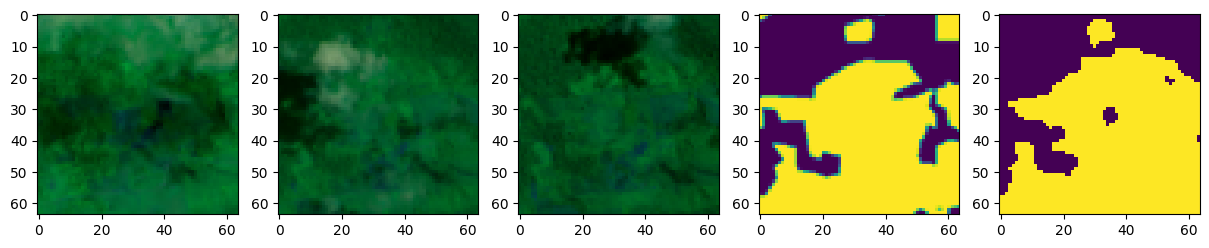

In [12]:
plot_images()